# SOFIAMIP raw data
- the raw data can be cmorized with `SOFIAMIP_cmorized_data_overview.ipynb`

In [1]:
import os
import sys
# import fnmatch
import matplotlib.pyplot as plt
sys.path.append('..')

from ece_output import sofiamip_exps

## check for presence of raw output data on $SCRATCH
- output data is backed up on ECFS
- can be retrieved with [ece3-raw-backup](https://github.com/plesager/ece3-raw-backup) scripts
- in `/ec/res4/hpcperm/nkaj/ece3-raw-backup` there is `get_sofiamip_runs.sh` that can be submitted to slurm via `sbatch get_sofiamip_runs.sh`
- data can be kept alive on `$SCRATCH` with crontab job

so many years are present: 798/800 years, fractionally of 4 100-year runs: 0.9975


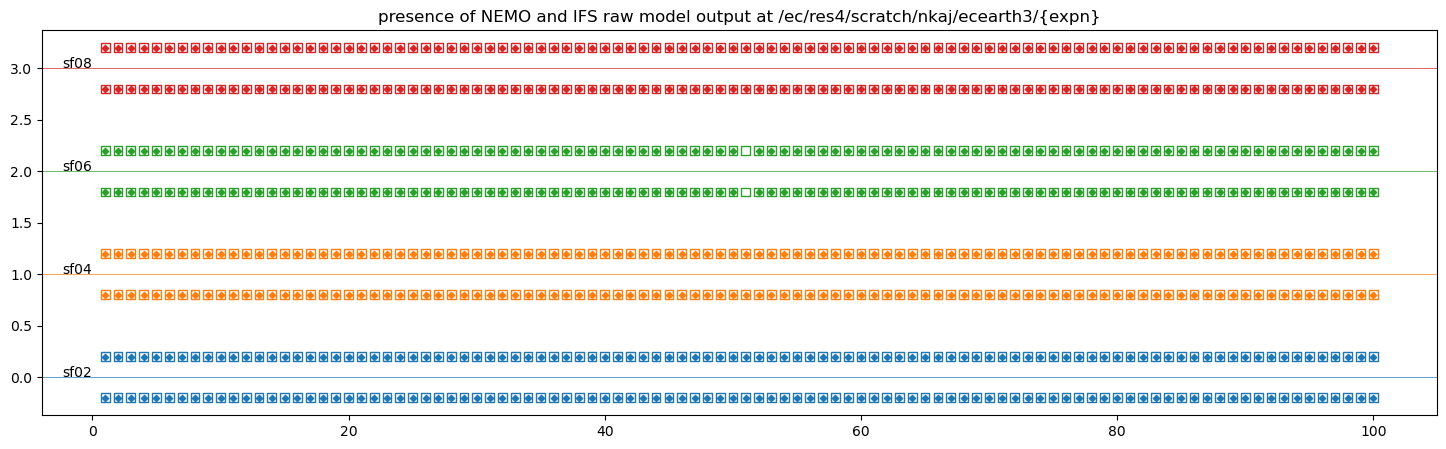

In [10]:
plt.figure(figsize=(18,5))
a = 0
for e, expn in enumerate(sofiamip_exps):
    plt.axhline(e, c=f'C{e}', lw=.5)
    # plt.axhline(e+14/20, c=f'C{e}', lw=.5)
    plt.text(0,e, expn, horizontalalignment='right')
    # print(expn)
    for m, model in enumerate(['nemo','ifs']):
        N = [14, 24][m] # expected number of files for nemo/ifs
        output_path = f'/ec/res4/scratch/nkaj/ecearth3/{expn}/output/{model}'
        for year_folder in sorted(os.listdir(output_path)):
            try:
                year = int(year_folder)
                assert type(year)==int
                output_folder = f'{output_path}/{year_folder}'
                # number of files in folder
                n = len(os.listdir(output_folder))
                if model=='ifs' and year==1:
                    n = n-2  # the first years have 2 extra files in the IFS output
                y =  e-.2+0.4*m
                plt.scatter(year,y, marker='s', s=40, edgecolor=f'C{e}', facecolor='none')
                if n==N:  # expected number of files
                    plt.scatter(year,y, marker='D', s=10, c=f'C{e}')
                    a += 1
                elif n==0:  # no output
                    continue
                elif n>N:  #  more than regular output, likely .gz artifacts from incomplete moving from tape
                    plt.scatter(year,y, marker=10, s=10, c='k')
                    a += 1
                else:  # partial output
                    print(f'exp: {expn} model {model} year {year_folder} only partial data: only {n} files')
                    plt.scatter(year,y, marker=11, s=10, c='k')
            except:
                continue
plt.title('presence of NEMO and IFS raw model output at /ec/res4/scratch/nkaj/ecearth3/{expn}')
print(f'so many years are present: {a}/800 years, fractionally of 4 100-year runs: {a/800}')

- sf06 year 51 is missing, also on the tape

### removing .gz files from incomplete ECFS data transfers

In [12]:
for exp in sofiamip_exps:
    for model in ['ifs','nemo']:
        for year in range(1,101):
            dir = f'/ec/res4/scratch/nkaj/ecearth3/{exp}/output/{model}/{year:03d}'
            for filename in os.listdir(dir):
                if '.gz' in filename:
                    print(filename)
                    os.remove(f'{dir}/{filename}')
                

sf08_1m_19490101_19491231_opa_grid_T_3D.nc.gz
sf08_1m_19490101_19491231_opa_grid_U_2D.nc.gz
sf08_1m_19490101_19491231_opa_grid_ptr_T_3basin_2D.nc.gz
sf08_1m_19490101_19491231_lim_grid_U_2D.nc.gz
sf08_1m_19490101_19491231_opa_grid_ptr_W_3basin_3D.nc.gz
sf08_1m_19490101_19491231_opa_grid_V_3D.nc.gz
sf08_1m_19490101_19491231_lim_grid_V_2D.nc.gz
sf08_1y_19490101_19491231_opa_grid_T_2D.nc.gz
sf08_1m_19490101_19491231_opa_grid_1point.nc.gz
sf08_1m_19490101_19491231_opa_grid_U_3D.nc.gz


### removing size-zero files
- execute this in the terminal in a folder `find  . -size 0 -print -delete`

## create sbatch script to (re-)download raw data from ECFS
- the cells below create the parallelized ece3-raw-backup/retrieve-ece3.sh instructions for the sbatch jib
- the following sbatch header needs to preceed the script generated below
```bash
#! /usr/bin/env bash

#SBATCH --qos=nf
#SBATCH --ntasks=1
#SBATCH --output=log/rtrv_sofiamip.%j.out
#SBATCH --time=48:00:00

cd /hpcperm/nkaj/ece3-raw-backup/
```
see `ECFS_data.ipynb` notebook